In [100]:
#IMPORTS
#Install+Import Packages
!pip install mechanize
import random
import re
import mechanize
import numpy as np
from random import *
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter 
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import filterfalse
from matplotlib.pyplot import figure
import scipy.stats as stats
import pylab
#!pip install ipython-autotime

In [183]:
#Upload Data and Define Parameters

file_type = '.fastq'

#Con0
aa_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1-1-gly_S3_L001_R1_001.fastq').readlines()
rna_only_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1-1-gly-NaOH_S4_L001_R1_001.fastq').readlines()
#Con1
#aa_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/new gly constructs/Cons1_S1_L001_R1_001.fastq').readlines()
#rna_only_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/new gly constructs/Cons1-NaOH_S2_L001_R1_001.fastq').readlines()
#Con2
#aa_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/new gly constructs/Cons2_S3_L001_R1_001.fastq').readlines()
#rna_only_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/new gly constructs/Cons2-NaOH_S4_L001_R1_001.fastq').readlines()
#Con3
#aa_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/new gly constructs/Cons3_S5_L001_R1_001.fastq').readlines()
#rna_only_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/new gly constructs/Cons3-NaOH_S6_L001_R1_001.fastq').readlines()

#Take the reverse complement? Enter 'yes' or 'no'
rc = 'no'

#Quality Cutoff - what fraction of positions should have <1% error probability?
quality_cutoff = 0.9


#Position motif1 starts at
motif_start = 1
#Motif1 define
motif = 'AAAGCC'
#Position motif2 starts at
motif2_start = 20
#Motif2 define
motif2 = 'GGCAAAAGATCGGAAGAGCACACGTCT'



In [184]:
def preprocess_seqs(list_of_seqs):

    if file_type == '.fastq':
        seqs = list_of_seqs[1::4]
        qualities = list_of_seqs[3::4]
        print('Total seqs: '+str(len(seqs)))

        #Filter by quality
        high_quality = []
        acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
        for seq in range(len(qualities)):
            overlap=0
            for char in list(set(qualities[seq]).intersection(acceptable_quals_1_percent_error)):
                overlap+=qualities[seq].count(char)
            if overlap/len(qualities[1])>quality_cutoff:
                high_quality.append(seqs[seq].strip("\n"))
        print('High quality seqs: '+str(len(high_quality)))
    
    if file_type == '.fasta':
        high_quality = list_of_seqs[1::2]
        print('Total seqs: '+str(len(high_quality)))
    
    #Take RC if desired
    pre_trim = []
    if rc == 'yes':
        rc_seqs = []
        for sequence in high_quality:
            rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n'))
        pre_trim = rc_seqs
    else:
        for sequence in high_quality:
            pre_trim.append(str(Seq(sequence)).strip('\n'))
    if rc == 'yes':
        print('Reverse Comp = '+str(rc)) 

    #Trim to keep only seqs with constant region
    trimmed = []
    for seq in pre_trim:
        if motif in seq:
            if motif2 in seq:
                if (motif2_start - motif_start - len(motif)) == len(seq[(motif_start-1)+len(motif):(motif2_start-1)]):
                    trimmed.append('GCC'+seq[(motif_start-1)+len(motif):(motif2_start-1)]+'GGC')
    print('Seqs after trimming: '+str(len(trimmed))) 
    
    #All processed seqs
    processed_seqs = trimmed
    #Unique seqs
    processed_seqs_unique = list(set(trimmed))
    
    return processed_seqs, processed_seqs_unique


def rscape_format(num_seqs_to_analyze, top_seqs):
    #Create file for R-Scape Covariation
    f = open("/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/gly_rscape"+str(num_seqs_to_analyze)+".txt", "w")
    f.write('# STOCKHOLM 1.0\n')
    f.write('\n')
    counter = 0
    for seq in top_seqs[:num_seqs_to_analyze]:
      counter+=1
      f.write(str(counter)+'\t'+seq[0]+'\n')
    #f.write('#=GC SS_cons	(((((((((,)))))))))\n')
    f.write('//')
    
def make_heatmap_bp(position_lhs, aa_not_rna_top_seqs):
    print(str(position_lhs+1)+'/'+ str(len(aa_not_rna_top_seqs[0])-position_lhs))
    bps = []
    for seq in range(len(aa_not_rna_top_seqs)):
        bps.append([aa_not_rna_top_seqs[seq][0][position_lhs], aa_not_rna_top_seqs[seq][0][len(aa_not_rna_top_seqs[seq][0])-position_lhs-1]])
    bp_options = [['A', 'A'],['A', 'C'],['A', 'G'],['A', 'T'],['C', 'A'],['C', 'C'],['C', 'G'],['C', 'T'],['G', 'A'],['G', 'C'],['G', 'G'],['G', 'T'],['T', 'A'],['T', 'C'],['T', 'G'],['T', 'T']]
    option_counts = []
    for option in bp_options:
        option_counts.append(bps.count(option))
    
    xticks = ['A','C','G','T']
    yticks = ['A','C','G','T']
    sns.heatmap(np.array(option_counts).reshape(4,4), cmap='coolwarm', xticklabels=xticks, yticklabels=yticks)
    print(option_counts)
    plt.title('BP '+str(position_lhs+1))
    plt.show()
    
    
    

In [185]:
#AA CONTROL
#STATISTICS (note: this takes a few mins per round)
aa_ctrl_processed_seqs, aa_ctrl_processed_seqs_unique = preprocess_seqs(aa_sequences)
aa_ctrl_top_seqs = Counter(aa_ctrl_processed_seqs).most_common(100)
print(aa_ctrl_top_seqs[:10])
print('Unique seqs '+str(len(aa_ctrl_processed_seqs_unique)))


Total seqs: 2818273
High quality seqs: 2725931
Seqs after trimming: 2204540
[('GCCGGCAAAAGATCGGGGC', 676), ('GCCGGGGGGGCAAAAGGGC', 267), ('GCCGGGGGGGGCAAAAGGC', 261), ('GCCGGGGGGCAAAAGAGGC', 249), ('GCCGGGCAAAAGATCGGGC', 243), ('GCCGGGGCAAAAGATCGGC', 181), ('GCCGGGGCGGCAAAAGGGC', 169), ('GCCGGGGTGGCAAAAGGGC', 146), ('GCCGGGGGTGGCAAAAGGC', 139), ('GCCGAGGGGGCAAAAGGGC', 129)]
Unique seqs 1669453


In [186]:
#RNA CONTROL
#STATISTICS (note: this takes a few mins per round)
rna_ctrl_processed_seqs, rna_ctrl_processed_seqs_unique = preprocess_seqs(rna_only_sequences)
rna_ctrl_top_seqs = Counter(rna_ctrl_processed_seqs).most_common(100)
print(rna_ctrl_top_seqs[:10])
print('Unique seqs '+str(len(rna_ctrl_processed_seqs_unique)))



Total seqs: 681129
High quality seqs: 651333
Seqs after trimming: 456806
[('GCCGGCAAAAGATCGGGGC', 684), ('GCCTGGCAAAAGATCGGGC', 132), ('GCCGGGTGGCAAAAGAGGC', 128), ('GCCCGGCAAAAGATCGGGC', 127), ('GCCGGGCAAAAGATCGGGC', 123), ('GCCGGGGGTGGCAAAAGGC', 111), ('GCCGGGGGGCAAAAGAGGC', 99), ('GCCGGGGTGGCAAAAGGGC', 93), ('GCCGGTGGGCAAAAGAGGC', 90), ('GCCGGGGGGGCAAAAGGGC', 83)]
Unique seqs 418946


In [187]:
#AA NOT RNA 
#STATISTICS (note: this takes a few mins per round)

aa_rna_no_overlap = list(filterfalse(set(rna_ctrl_processed_seqs).__contains__, aa_ctrl_processed_seqs))

print('Seqs in AA but not RNA: '+str(round(len(aa_rna_no_overlap))))

aa_not_rna_top_seqs = Counter(aa_rna_no_overlap).most_common(10000)
print(aa_not_rna_top_seqs[:10])

print('Unique seqs '+str(len(set(aa_rna_no_overlap))))
#Save file for R-Scape
rscape_format(1002, aa_not_rna_top_seqs)
print('R-Scape file saved')

Seqs in AA but not RNA: 2056465
[('GCCTGATTGTAGATTGGGC', 88), ('GCCAGTTTGTAGAATTGGC', 61), ('GCCGTCTTGTAGAGAGGGC', 60), ('GCCTGTTTGTAGAATGGGC', 60), ('GCCGGAGCGTAAGTGAGGC', 59), ('GCCGGTCGTGGCGATTGGC', 54), ('GCCGAGTTGTAGATGAGGC', 52), ('GCCGGAGGGGAACTCTGGC', 48), ('GCCAGTTTGAGGGATTGGC', 47), ('GCCGGATTGAGGGTTCGGC', 46)]
Unique seqs 1590845
R-Scape file saved


In [188]:
#Save file for R-Scape
rscape_format(1000, Counter(rna_ctrl_processed_seqs).most_common(1000))
print('R-Scape file saved')

R-Scape file saved


1/2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 10000, 0, 0, 0, 0, 0, 0]


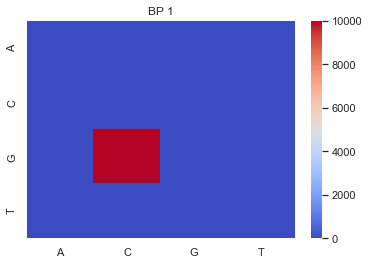

2/1
[0, 0, 0, 0, 0, 0, 10000, 0, 0, 0, 0, 0, 0, 0, 0, 0]


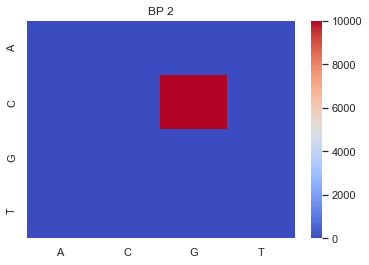

3/0
[0, 0, 0, 0, 0, 0, 10000, 0, 0, 0, 0, 0, 0, 0, 0, 0]


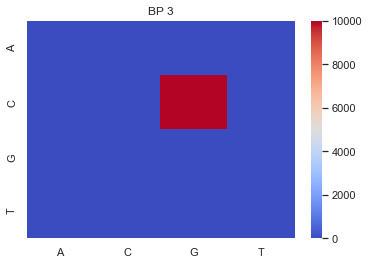

4/-1
[19, 35, 199, 2991, 14, 22, 798, 81, 137, 1469, 516, 1524, 1069, 42, 932, 152]


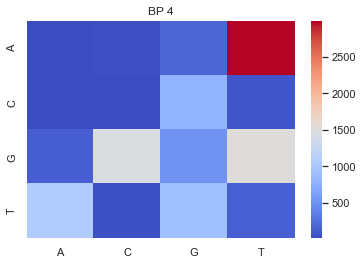

5/-2
[27, 30, 268, 2106, 13, 31, 1048, 66, 33, 890, 383, 679, 1722, 81, 2442, 181]


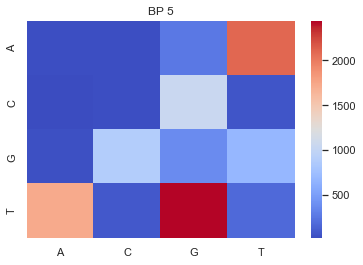

6/-3
[84, 60, 787, 1701, 21, 22, 1006, 38, 193, 729, 378, 553, 1538, 77, 2617, 196]


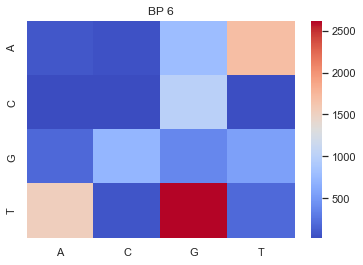

7/-4
[132, 44, 882, 1120, 44, 25, 642, 56, 574, 632, 1834, 922, 923, 90, 1778, 302]


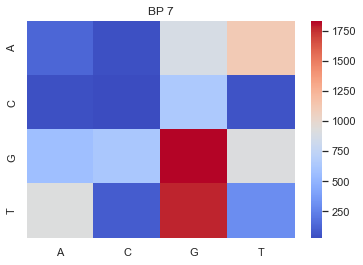

8/-5
[494, 156, 1281, 606, 197, 49, 656, 254, 593, 151, 1741, 863, 630, 155, 1529, 645]


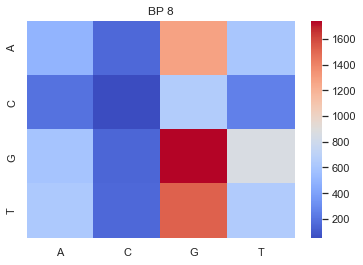

In [166]:
#Show Covariation
for i in range(8):
    make_heatmap_bp(i, aa_not_rna_top_seqs)

1/2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0]


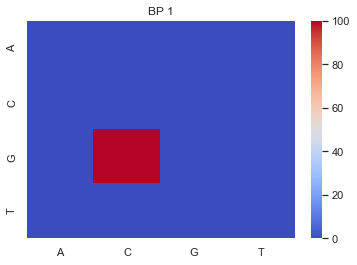

2/1
[0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0]


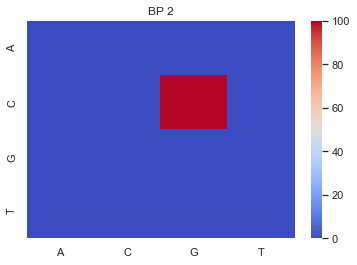

3/0
[0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0]


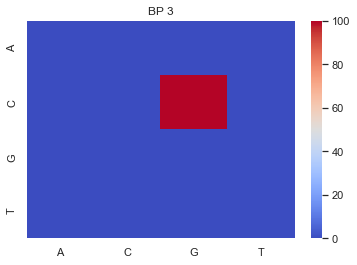

4/-1
[0, 0, 0, 34, 0, 0, 0, 0, 0, 4, 9, 41, 2, 0, 10, 0]


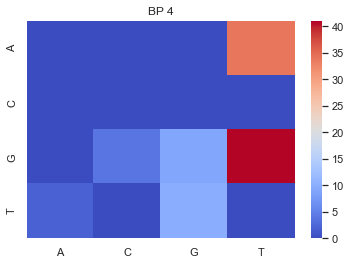

5/-2
[0, 0, 0, 34, 0, 0, 5, 0, 0, 3, 3, 13, 30, 0, 11, 1]


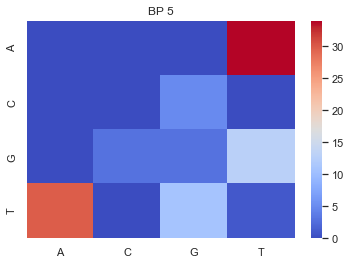

6/-3
[0, 0, 1, 40, 0, 1, 1, 0, 0, 5, 0, 9, 21, 0, 19, 3]


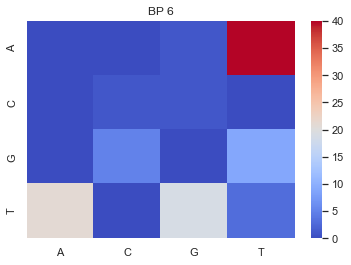

7/-4
[0, 0, 0, 30, 0, 0, 4, 0, 0, 20, 8, 1, 37, 0, 0, 0]


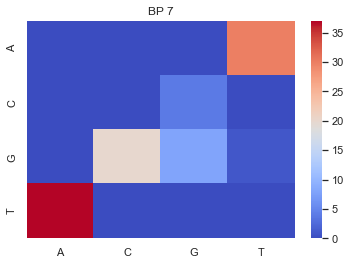

8/-5
[1, 0, 0, 0, 1, 8, 68, 17, 0, 0, 0, 0, 0, 0, 5, 0]


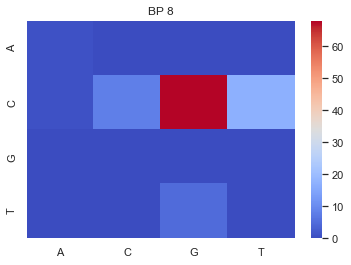

In [167]:
#Covariation for RNA Control
for i in range(8):
    make_heatmap_bp(i, rna_ctrl_top_seqs)

<Figure size 432x288 with 0 Axes>

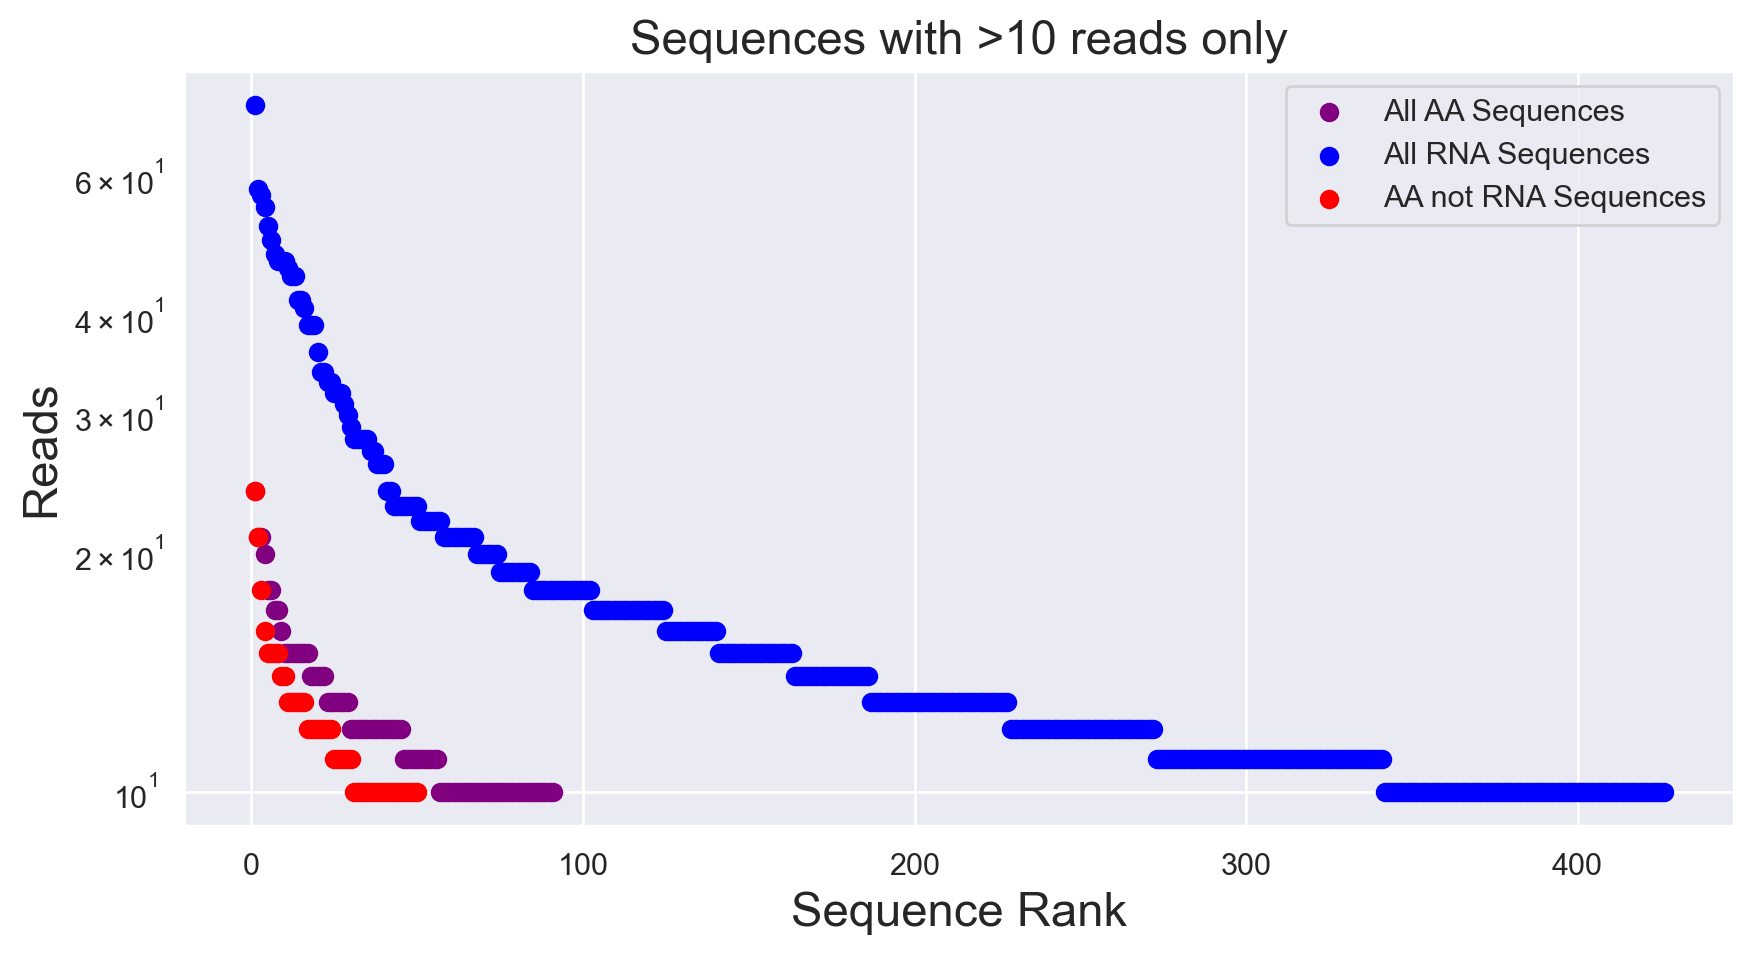

In [168]:
#Sutherland distribution plot all seqs with >10 reads
plt.figure(facecolor="white")
figure(figsize=(10, 5), dpi=200)
ordered_counts_aa = sorted(dict(Counter(aa_ctrl_processed_seqs)).values(), reverse=True)
ordered_counts_rna = sorted(dict(Counter(rna_ctrl_processed_seqs)).values(), reverse=True)
ordered_counts_aa_not_rna = sorted(dict(Counter(aa_rna_no_overlap)).values(), reverse=True)
plt.scatter(range(1,len([i for i in ordered_counts_aa if i >= 10])+1), [i for i in ordered_counts_aa if i >= 10], color = 'purple', label = 'All AA Sequences')
plt.scatter(range(1,len([i for i in ordered_counts_rna if i >= 10])+1), [i for i in ordered_counts_rna if i >= 10], color = 'blue', label = 'All RNA Sequences')
plt.scatter(range(1,len([i for i in ordered_counts_aa_not_rna if i >= 10])+1), [i for i in ordered_counts_aa_not_rna if i >= 10], color = 'red', label = 'AA not RNA Sequences')
plt.xlabel('Sequence Rank', fontsize = 17)
plt.ylabel('Reads', fontsize = 17)
plt.title('Sequences with >10 reads only', fontsize = 17)
plt.yscale('log')
plt.legend()


In [169]:
#How abundant is GUA in the top 10,000 sequences
triplet_options = []
top_1000_weighted = [item for items, c in Counter(aa_rna_no_overlap).most_common() for item in [items] * c]
for seq in top_1000_weighted[:1000]:
#for seq in list(set(Counter(aa_rna_no_overlap).most_common(len(aa_rna_no_overlap)))):
    triplet_options.append(seq[8:11])

triplets_present = {k: v for k, v in sorted(dict(Counter(triplet_options)).items(), key=lambda item: item[1], reverse=True)}

#Calculate Chi_Square
#All Possible Triplets
triplets_possible = []
for pos_1 in ['A','C','G','T']:
    for pos_2 in ['A','C','G','T']:
        for pos_3 in ['A','C','G','T']:
            codon = ''
            codon+=(pos_1+pos_2+pos_3)
            triplets_possible.append(codon)

observed_counts = list(triplets_present.values())+[0]*(len(triplets_possible)-len(list(triplets_present.values())))
expected_counts = (.25**3)*1000

chi_squared = 0
for observed in observed_counts:
    chi_squared+=(observed-expected_counts)**2/expected_counts

1 - stats.chi2.cdf(chi_squared, 2)


0.0

In [170]:
observed_counts

[327,
 324,
 108,
 106,
 57,
 29,
 11,
 11,
 10,
 9,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [172]:
#How abundant is GUA in the top sequences
triplet_options = []
top_1000_weighted = [item for items, c in Counter(aa_rna_no_overlap).most_common(50) for item in [items] * c]
for seq in top_1000_weighted:
#for seq in list(set(Counter(aa_rna_no_overlap).most_common(len(aa_rna_no_overlap)))):
    triplet_options.append(seq[6:13])

{k: v for k, v in sorted(dict(Counter(triplet_options)).items(), key=lambda item: item[1], reverse=True)}

{'GTGGTGG': 84,
 'GAGGTGG': 55,
 'GTGGTAG': 50,
 'GAGAGCT': 42,
 'AGGAGGT': 33,
 'GTGAGCA': 28,
 'GTGAGGT': 23,
 'GTGAGGC': 23,
 'GTGAGCT': 20,
 'GTGATTC': 18,
 'GTGAGTA': 15,
 'GTGAGAT': 15,
 'GAGAGAT': 14,
 'GAGATCT': 13,
 'TGCGGCG': 13,
 'GTAAGCT': 12,
 'TCGGTGG': 12,
 'GGAAGCT': 12,
 'GTGATAA': 12,
 'GTGATTA': 11,
 'GAAATCT': 11,
 'GAGAACT': 11,
 'TGGGGGA': 10,
 'GAGAGCA': 10,
 'TAGGGAC': 10,
 'GAGAGTT': 10,
 'AGGGGGT': 10,
 'TTGTGGG': 10,
 'GAGATTC': 10,
 'TGGGGTG': 10}

In [113]:
#How abundant is GUA in the top sequences
triplet_options = []
top_1000_weighted = [item for items, c in Counter(aa_rna_no_overlap).most_common() for item in [items] * c]
for seq in top_1000_weighted:
#for seq in list(set(Counter(aa_rna_no_overlap).most_common(len(aa_rna_no_overlap)))):
    triplet_options.append(seq[8:11])

{k: v for k, v in sorted(dict(Counter(triplet_options)).items(), key=lambda item: item[1], reverse=True)}

{'TGG': 113038,
 'GGG': 111614,
 'CGG': 88934,
 'GCG': 71996,
 'GGA': 71935,
 'GTG': 66341,
 'TTG': 60595,
 'AGG': 59846,
 'GAG': 57720,
 'TAG': 56890,
 'TGA': 56886,
 'CGC': 53325,
 'TCG': 52535,
 'GTA': 50772,
 'CTG': 47949,
 'CAG': 46217,
 'CCG': 45292,
 'TGC': 43554,
 'TGT': 43357,
 'CGA': 40775,
 'TTA': 40110,
 'AGA': 38515,
 'ATG': 35153,
 'CGT': 33718,
 'GGT': 31032,
 'AGT': 30626,
 'GCC': 27552,
 'GGC': 27258,
 'GCA': 26714,
 'GTT': 26658,
 'TAA': 24162,
 'GTC': 23023,
 'TTT': 22788,
 'CCC': 22432,
 'GAA': 22317,
 'TCA': 20841,
 'ATA': 20401,
 'AAG': 20298,
 'ACG': 20197,
 'TCC': 19732,
 'CCA': 19680,
 'TAT': 19494,
 'CTA': 19300,
 'TTC': 19091,
 'CTC': 16192,
 'GAT': 16138,
 'AGC': 15169,
 'CCT': 14725,
 'ATT': 14071,
 'TCT': 13917,
 'GAC': 11094,
 'CAC': 10667,
 'TAC': 10561,
 'CTT': 10313,
 'GCT': 9826,
 'AAA': 9543,
 'ATC': 8724,
 'ACA': 8159,
 'CAT': 7942,
 'CAA': 7613,
 'AAT': 6683,
 'ACC': 6416,
 'ACT': 5169,
 'AAC': 2880}

In [58]:
#How abundant are different aminoacylated connections in the top 1,000 sequences
bond_options = []
top_1000_weighted = [item for items, c in Counter(list(set(aa_rna_no_overlap))).most_common() for item in [items] * c]
for seq in top_1000_weighted[:1000]:
#for seq in list(set(Counter(aa_rna_no_overlap).most_common(len(aa_rna_no_overlap)))):
    bond_options.append(seq[10:12])

{k: v for k, v in sorted(dict(Counter(bond_options)).items(), key=lambda item: item[1], reverse=True)}

{'GG': 236,
 'GA': 136,
 'GT': 105,
 'AG': 81,
 'TG': 73,
 'AA': 62,
 'CG': 61,
 'TA': 57,
 'AT': 40,
 'CA': 29,
 'CT': 26,
 'TC': 26,
 'TT': 25,
 'AC': 23,
 'GC': 14,
 'CC': 6}

In [59]:
#How abundant are different RNA-CONTROL connections in the top 1,000 sequences
bond_options = []
top_1000_weighted = [item for items, c in Counter(list(set(rna_ctrl_processed_seqs))).most_common() for item in [items] * c]
for seq in top_1000_weighted[:1000]:
#for seq in list(set(Counter(aa_rna_no_overlap).most_common(len(aa_rna_no_overlap)))):
    bond_options.append(seq[10:12])

{k: v for k, v in sorted(dict(Counter(bond_options)).items(), key=lambda item: item[1], reverse=True)}

{'GG': 120,
 'CG': 96,
 'GT': 90,
 'AG': 85,
 'CC': 85,
 'AT': 80,
 'CT': 75,
 'TC': 65,
 'TG': 53,
 'CA': 51,
 'GA': 40,
 'AC': 38,
 'TT': 37,
 'AA': 36,
 'TA': 29,
 'GC': 20}